In [1]:
import numpy as np
import scipy
import scipy.sparse as sp
import scipy.optimize as so

In [2]:
# A = smat
# # A = sp.rand(200000, 200000, density=1e-5)
# b = np.random.randn(size)
# lb = np.random.randn(size)
# ub = lb + 0.2
# res = so.lsq_linear(A, b, bounds=(lb, ub), method='trf', max_iter=10 , tol=1e-5, lsmr_tol='auto', verbose=1)

In [3]:
# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
np.set_printoptions(edgeitems=10, linewidth=10000, formatter=dict(float=lambda x: "%.3f" % x))# np.set_printoptions(suppress=True)

In [4]:
from diffusion_curve import DiffusionCurve
from PIL import Image
from matplotlib.pyplot import imshow
import utils

In [5]:
# paint
def paint(data, mask):
    PIL_data = 255*np.ones((data.shape[1], data.shape[0], 3), dtype=np.uint8)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if mask[i, j]:
                for k in range(3):
                    PIL_data[j, i, k] = utils.get_int_color(data[i, j, k])
    img = Image.fromarray(PIL_data, 'RGB')
    %matplotlib inline
    imshow(np.asarray(img))

In [6]:
width = 512 # must be square, or there might be bug
height = 512
curve = DiffusionCurve(width, height)
curve.ctx_points = [(0.3, 0.3), (0.4, 0.4), (0.5, 0.5), (0.7, 0.7)]
left_color = [(255, 0, 255, 0.0), (255, 0, 0, 1.)]
right_color = [(0, 0, 255, 0.0), (255, 255, 0, 1.)]

curve.color_pts_left = [(x[0]/255, x[1]/255, x[2]/255, x[3]) for x in left_color]
curve.color_pts_right = [(x[0]/255, x[1]/255, x[2]/255, x[3]) for x in right_color]

curve.rasterize_curve()
curve.rasterize_color_source()
curve.calc_divergence()

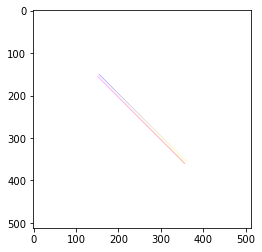

In [7]:
p = paint(curve.color_source, curve.color_source_mask)

In [8]:
L = utils.laplacian(width, height)
divw = curve.divergence.reshape(-1, 3)
min_constraint = np.zeros((width, height, 3), dtype=np.float32)
max_constraint = np.full((width, height, 3), np.inf, dtype=np.float32)

for i in range(height):
    for j in range(width):
        if curve.color_source_mask[i, j]:
            min_constraint[i, j] = curve.color_source[i, j]-1e-5
            max_constraint[i, j] = curve.color_source[i, j]+1e-5

min_constraint = min_constraint.reshape(-1, 3)
max_constraint = max_constraint.reshape(-1, 3)

In [9]:
# %timeit
# X = np.zeros((width, height, 3), dtype=np.float32)

# for i in range(3):
#     res = so.lsq_linear(L, divw[:,i], method='trf', bounds=(min_constraint[:,i], max_constraint[:,i]), max_iter=1, tol=1e-5, lsmr_tol='auto', verbose=1)
#     X[:, :, i] = res.x.reshape(width, height)
# mask = np.full((width, height), True)
# paint(X, mask)

In [10]:
# kernel = np.array([
#     [0.25, 0.5, 0.25],
#     [0.5, 1, 0.5],
#     [0.25, 0.5, 0.25]
# ], dtype=np.float32)
def downsample_gradient(X: np.array)->np.array:
#     def filterStride2(a):
#         a = utils.conv2d(utils.padding(a), kernel)
#         return a[np.ix_(range(1, a.shape[0], 2), range(1, a.shape[1], 2))]
#     cur_dim = X.shape[0]
#     next_dim = X.shape[0]//2
#     print(filterStride2(X[:, :, 0]).shape)
#     result = np.zeros((next_dim, next_dim, 3), dtype=np.float32)
#     for i in range(3):
#         result[:, :, i] = filterStride2(X[:, :, i])
#     return result

    n = X.shape[1]
    m = n//2
    Y = np.zeros((m, m, 3), dtype=X.dtype)
    for i in range(m):
        for j in range(m):
            count = 4
            Y[i, j] = (X[2*i, 2*j]+X[2*i+1, 2*j]+X[2*i, 2*j+1]+X[2*i+1, 2*j+1]) / count
    return Y

In [11]:
# downsample image
# n*n -> (n/2)*(n/2)
# NOTE DONT average on uncolor pixels, they do not count
def downsample_pixels(X: np.array, mask: np.array) -> (np.array, np.array):
    n = X.shape[1]
    m = n//2
    Y = np.zeros((m, m, 3), dtype=X.dtype)
    new_mask = np.full((m, m), False)
    for i in range(m):
        for j in range(m):
            sub_idx = np.ix_([2*i, 2*i+1], [2*j, 2*j+1])
            count = np.sum(1*mask[sub_idx])
            new_mask[i, j] = count > 0
            if count > 0:
                Y[i, j] = (X[2*i, 2*j]+X[2*i+1, 2*j]+X[2*i, 2*j+1]+X[2*i+1, 2*j+1]) / count
    return Y, new_mask

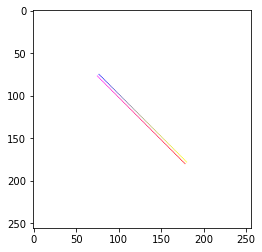

In [12]:
gradx_256 = downsample_gradient(curve.wx)
grady_256 = downsample_gradient(curve.wy)
div_256 = utils.calc_curve_divergence(gradx_256, grady_256)
# paint 256 coarse picture
pixels_256, mask_256 = downsample_pixels(curve.color_source, curve.color_source_mask)
paint(pixels_256, mask_256)

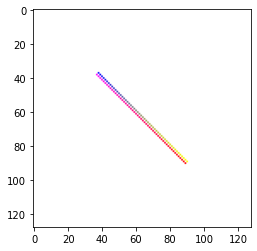

In [13]:
gradx_128 = downsample_gradient(gradx_256)
grady_128 = downsample_gradient(grady_256)
div_128 = utils.calc_curve_divergence(gradx_128, grady_128)
pixels_128, mask_128 = downsample_pixels(pixels_256, mask_256)
paint(pixels_128, mask_128)

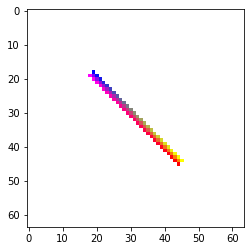

In [14]:
gradx_64 = downsample_gradient(gradx_128)
grady_64 = downsample_gradient(grady_128)
div_64 = utils.calc_curve_divergence(gradx_64, grady_64)
pixels_64, mask_64 = downsample_pixels(pixels_128, mask_128)
paint(pixels_64, mask_64)

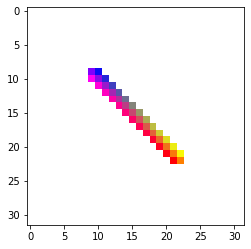

In [15]:
gradx_32 = downsample_gradient(gradx_64)
grady_32 = downsample_gradient(grady_64)
div_32 = utils.calc_curve_divergence(gradx_32, grady_32)
pixels_32, mask_32 = downsample_pixels(pixels_64, mask_64)
paint(pixels_32, mask_32)

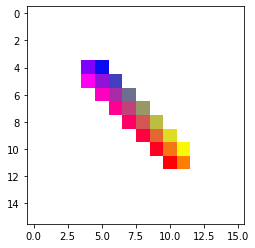

In [16]:
gradx_16 = downsample_gradient(gradx_32)
grady_16 = downsample_gradient(grady_32)
div_16 = utils.calc_curve_divergence(gradx_16, grady_16)
pixels_16, mask_16 = downsample_pixels(pixels_32, mask_32)
paint(pixels_16, mask_16)

The maximum number of iterations is exceeded.
Number of iterations 20, initial cost 3.9654e+01, final cost 1.8044e+00, first-order optimality 4.66e-02.
The maximum number of iterations is exceeded.
Number of iterations 20, initial cost 1.8234e+01, final cost 2.6641e+00, first-order optimality 1.37e-03.
The maximum number of iterations is exceeded.
Number of iterations 20, initial cost 1.4215e+01, final cost 3.1774e-01, first-order optimality 3.20e-03.


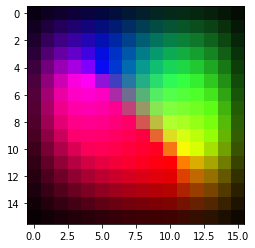

In [17]:
# solve 16X16 direcly
n = 16
L_16 = utils.laplacian(n, n)
divw = div_16.reshape(-1, 3)
min_constraint = np.zeros((n, n, 3), dtype=np.float32)
max_constraint = np.full((n, n, 3), np.inf, dtype=np.float32)

for i in range(n):
    for j in range(n):
        if mask_16[i, j]:
            min_constraint[i, j] = pixels_16[i, j]-1e-5
            max_constraint[i, j] = pixels_16[i, j]+1e-5

min_constraint = min_constraint.reshape(-1, 3)
max_constraint = max_constraint.reshape(-1, 3)

x_16 = np.zeros((n, n, 3), dtype=np.float32)

for i in range(3):
    res = so.lsq_linear(L_16, divw[:,i], method='trf', bounds=(min_constraint[:,i], max_constraint[:,i]), max_iter=20, tol=1e-6, verbose=1)
    x_16[:, :, i] = res.x.reshape(n, n)
paint(x_16, np.full((n, n), True))

In [18]:
# from coarse to finer
# in other words, interpolation from the smaller size to bigger one
def upsample(X: np.array) -> np.array:
    m = X.shape[0]
    n = m*2
    Y = np.zeros((n,n,3), dtype=X.dtype)
    for i in range(m):
        for j in range(m):
            Y[2*i, 2*j] = Y[2*i, 2*j+1] = Y[2*i+1, 2*j] = Y[2*i+1, 2*j+1] = X[i, j]
            
    return Y

In [19]:
# diffusion
def jacobi_relaxation(X0: np.array, divw: np.array, constraint, mask, max_iter = 5):
    n = X0.shape[0]
    def is_valid_idx(idx):
        i, j = idx
        return i >= 0 and j >= 0 and i < n and j < n
    X = np.zeros(X0.shape, X0.dtype)
    for k in range(max_iter):
        for i in range(n):
            for j in range(n):
                count = 0
                for offset in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    neighbor_idx = (i+offset[0], j+offset[1])
                    if is_valid_idx(neighbor_idx):
                        count += 1
                        X[i, j] += X0[neighbor_idx]
                
                X[i, j] -= divw[i, j]
                X[i, j] /= count
        X0, X = X, X0
        # import constraint
        X0[mask] = constraint[mask]
        X.fill(0)
    return X0

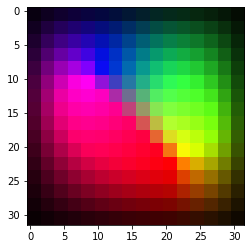

In [20]:
x0 = x_16
n = 32
x_32 = upsample(x0)
paint(x_32, np.full((n, n), True))

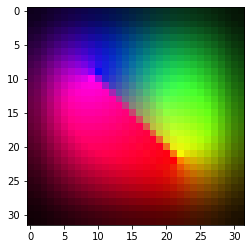

In [21]:
x = x_32
div = div_32
n = 32
x_32 = jacobi_relaxation(x, div, pixels_32, mask_32)
paint(x_32, np.full((n, n), True))

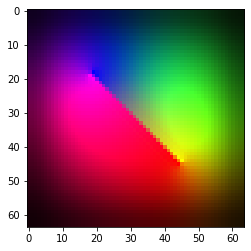

In [22]:
x_64 = upsample(x_32)
x = x_64
div = div_64
x_64 = jacobi_relaxation(x, div, pixels_64, mask_64)
n = x.shape[0]
paint(x_64, np.full((n, n), True))

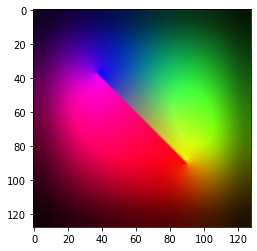

In [23]:
x_128 = upsample(x_64)
x = x_128
div = div_128
x_128 = jacobi_relaxation(x, div, pixels_128, mask_128)
n = x.shape[0]
paint(x_128, np.full((n, n), True))

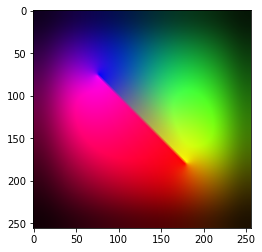

In [24]:
x_256 = upsample(x_128)
x = x_256
div = div_256
x_256 = jacobi_relaxation(x, div, pixels_256, mask_256, max_iter=2)
n = x.shape[0]
paint(x_256, np.full((n, n), True))

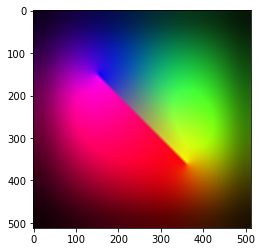

In [25]:
x_512 = upsample(x_256)
x = x_512
div = curve.divergence
x_512 = jacobi_relaxation(x, div, curve.color_source, curve.color_source_mask, max_iter=1)
n = x.shape[0]
paint(x_512, np.full((n, n), True))

In [26]:
from diffusion import diffuse
pyramid = diffuse([curve], 512)

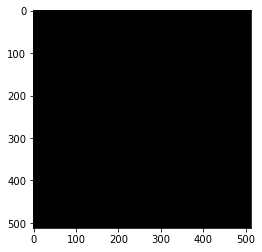

In [27]:
n = 512
paint(pyramid[0], np.full((n, n), True))

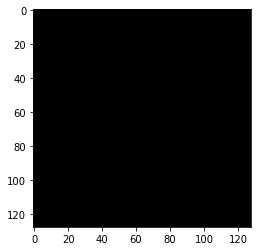

In [28]:
paint(pyramid[2], np.full((n, n), True))

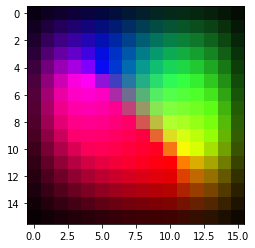

In [29]:
paint(pyramid[-1], np.full((n, n), True))